# End-to-End prosody transfer prototype using QuartzNet, Mellotron, Tacotron, WaveGlow, Multi-Singer and HiFiGAN.
This notebook uses resources from following repositories: 
 - https://github.com/NVIDIA/mellotron
 - https://github.com/NVIDIA/NeMo
 - https://github.com/Rongjiehuang/Multi-Singer
 - https://github.com/NVIDIA/waveglow.git

and is designed to run in google colab. If you want to run it locally, you might be required to install many additional dependencies!

This notebook requires a GPU to run properly. 
First, you must select in the top left corner => `Runtime` / `Change runtime type` => and here select a `GPU` option.

*Create GLOBAL variables necessary throughout the document*




In [1]:
transcribedText = ""

In [2]:
# make sure we are in the correct location
%cd /content/
! ls

/content
drive  examples_filelist.txt  mellotron  Multi-Singer  sample_data


In [3]:
# create new file for audio/text inference linkage
! touch examples_filelist.txt

Mounting a personal google drive with pretrained models: choose the correct account and allow access...

In [4]:
# Mounting a personal google drive with pretrained models: choose the correct account and allow access...
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


*If the repo already exists in your local files, run the cell below to get rid of it and instatantiate new copy*


In [5]:
# remove repository from previous testing instances
! rm -r mellotron
# clone the Mellotron repository
! git clone https://github.com/NVIDIA/mellotron.git

Cloning into 'mellotron'...
remote: Enumerating objects: 164, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 164 (delta 2), reused 2 (delta 0), pack-reused 155
Receiving objects: 100% (164/164), 3.38 MiB | 9.86 MiB/s, done.
Resolving deltas: 100% (68/68), done.


Descend into the repo and list directory contents

In [6]:
%cd /content/mellotron
! ls

/content/mellotron
audio_processing.py  inference.ipynb	 mellotron_utils.py  stft.py
data		     layers.py		 model.py	     text
data_utils.py	     LICENSE		 modules.py	     train.py
distributed.py	     logger.py		 multiproc.py	     utils.py
filelists	     loss_function.py	 plotting_utils.py   waveglow
fp16_optimizer.py    loss_scaler.py	 README.md	     yin.py
hparams.py	     mellotron_logo.png  requirements.txt


Name your source audio clip reference_clip.wav and upload it into the root folder/content/mellotron/data/ of this colab instance. This must be done after the mellotron repository is instantiated!

*The clip must be a wave file (.wav) with mono channel and 22050Hz frequency!*

# Initialize Nvidia NeMo Framework + dependencies
The following block will import the NeMo framework from github.

In [7]:
## Install dependencies
!pip install wget
!apt-get install sox libsndfile1 ffmpeg
!pip install unidecode

# ## Install NeMo
BRANCH = 'main'
!python -m pip install git+https://github.com/NVIDIA/NeMo.git@$BRANCH#egg=nemo_toolkit[all]

## Install TorchAudio
!pip install torchaudio>=0.10.0 -f https://download.pytorch.org/whl/torch_stable.html

## Grab the config we'll use in this example
!mkdir configs

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libsndfile1 is already the newest version (1.0.28-4ubuntu0.18.04.2).
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
sox is already the newest version (14.4.2-3ubuntu0.18.04.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-470
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
  Cloning https://github.com/NVIDIA/NeMo.git (to revision main) to /tmp/pip-install-l5lrk5yw/nemo-toolkit_1194cbbed4264e23b2494744e25d442a
  Running command git clone -q https://github.com/NVIDIA/NeMo.git /tmp/pip-install-l5lrk5yw/nemo-toolkit_1194cbbed4264e23b2494744e25d442a
  Using cached matplotlib-3.5.1-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (11.2 MB)
  Using cached nltk-3.7-py3-none-any.whl (1.5 MB)
  Using cached tensorboard-2.8.0-py3-none-any.whl (5.8 MB)
  Attempting uninstall: tensorboar

In [8]:
import nemo
nemo.__version__

'1.7.0'

## Initializing Git submodule for waveglow
WaveGlow is used as a default vocoder for Mellotron.

In [9]:
# this cell makes sure the sub-repository initially used by Mellotron is intialized
! git submodule init
! git submodule update

Submodule 'waveglow' (https://github.com/NVIDIA/waveglow.git) registered for path 'waveglow'
Cloning into '/content/mellotron/waveglow'...
Submodule path 'waveglow': checked out '2fd4e63e2918012f55eac2c8a8e75622a39741be'


Copy large files (pretrained models) from the mapped GDrive to the local filesystem.

In [10]:
!cp -r /content/drive/MyDrive/models/ .
! ls

'=0.10.0'	       hparams.py	    mellotron_utils.py	 stft.py
 audio_processing.py   inference.ipynb	    model.py		 text
 configs	       layers.py	    models		 train.py
 data		       LICENSE		    modules.py		 utils.py
 data_utils.py	       logger.py	    multiproc.py	 waveglow
 distributed.py        loss_function.py     plotting_utils.py	 yin.py
 filelists	       loss_scaler.py	    README.md
 fp16_optimizer.py     mellotron_logo.png   requirements.txt


Mellotron needs many dependencies as described by requirements.txt
- matplotlib==2.1.0
- tensorflow==1.15.2
- inflect==0.2.5
- librosa==0.6.0
- scipy==1.0.0
- tensorboardX==1.1
- Unidecode==1.0.22
- pillow
- nltk==3.4.5
- jamo==0.4.1
- music21

In [11]:
# We create a new requirement file, since google colab comes with many of these programs preinstalled and their succesive installation throws errors.
! touch newReqs.txt
! echo 'Unidecode==1.0.22' > newReqs.txt
! echo 'tensorflow==1.15.2' >> newReqs.txt

*Unidecode is not preinstalled by colab.*
*Tensorflow is included in colab, but versions 0.2.0 and newer removed an attribute called "contrib". Mellotron requires a older version of tensorflow to function properly.*

In [12]:
# requirement installation - can take a while.
! pip install -r newReqs.txt

  Using cached tensorboard-1.15.0-py3-none-any.whl (3.8 MB)
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytorch-lightning 1.5.10 requires tensorboard>=2.2.0, but you have tensorboard 1.15.0 which is incompatible.
kapre 0.3.7 requires tensorflow>=2.0.0, but you have tensorflow 1.15.2 which is incompatible.


## Mellotron Inference
Mellotron needs to instantiate and import many of its libraries to synthesize mel spectrograms.

In [13]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import IPython.display as ipd

import sys
sys.path.append('waveglow/')

from itertools import cycle
import numpy as np
import scipy as sp
from scipy.io.wavfile import write
import pandas as pd
import librosa
import torch

# importing custom Mellotron classes
from hparams import create_hparams
from model import Tacotron2, load_model
from waveglow.denoiser import Denoiser
from layers import TacotronSTFT
from data_utils import TextMelLoader, TextMelCollate
from text import cmudict, text_to_sequence
from mellotron_utils import get_data_from_musicxml

In [14]:
def panner(signal, angle):
    angle = np.radians(angle)
    left = np.sqrt(2)/2.0 * (np.cos(angle) - np.sin(angle)) * signal
    right = np.sqrt(2)/2.0 * (np.cos(angle) + np.sin(angle)) * signal
    return np.dstack((left, right))[0]

In [15]:
def plot_mel_f0_alignment(mel_source, mel_outputs_postnet, f0s, alignments, figsize=(16, 16)):
    fig, axes = plt.subplots(4, 1, figsize=figsize)
    axes = axes.flatten()
    axes[0].imshow(mel_source, aspect='auto', origin='bottom', interpolation='none')
    axes[1].imshow(mel_outputs_postnet, aspect='auto', origin='bottom', interpolation='none')
    axes[2].scatter(range(len(f0s)), f0s, alpha=0.5, color='red', marker='.', s=1)
    axes[2].set_xlim(0, len(f0s))
    axes[3].imshow(alignments, aspect='auto', origin='bottom', interpolation='none')
    axes[0].set_title("Source Mel")
    axes[1].set_title("Predicted Mel")
    axes[2].set_title("Source pitch contour")
    axes[3].set_title("Source rhythm")
    plt.tight_layout()

In [16]:
def load_mel(path):
    audio, sampling_rate = librosa.core.load(path, sr=hparams.sampling_rate)
    audio = torch.from_numpy(audio)
    if sampling_rate != hparams.sampling_rate:
        raise ValueError("{} SR doesn't match target {} SR".format(
            sampling_rate, stft.sampling_rate))
    audio_norm = audio.unsqueeze(0)
    audio_norm = torch.autograd.Variable(audio_norm, requires_grad=False)
    melspec = stft.mel_spectrogram(audio_norm)
    melspec = melspec.cuda()
    return melspec

In [17]:
hparams = create_hparams()

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Settings for the inner Tacotron model used as aligner.

In [18]:
stft = TacotronSTFT(hparams.filter_length, hparams.hop_length, hparams.win_length,
                    hparams.n_mel_channels, hparams.sampling_rate, hparams.mel_fmin,
                    hparams.mel_fmax)

## Loading pretrained models
The pretrained libriTts model for Mellotron is available from: https://drive.google.com/open?id=1ZesPPyRRKloltRIuRnGZ2LIUEuMSVjkI

In [19]:
# PATH to pretrained model
checkpoint_path = "models/mellotron_libritts.pt"
mellotron = load_model(hparams).cuda().eval()
mellotron.load_state_dict(torch.load(checkpoint_path)['state_dict'])

<All keys matched successfully>

The pretrained model for WaveGlow is available from: https://drive.google.com/open?id=1okuUstGoBe_qZ4qUEF8CcwEugHP7GM_b

In [20]:
# PATH to pretrained vocoder
waveglow_path = 'models/waveglow_256channels_universal_v4.pt'
waveglow = torch.load(waveglow_path)['model'].cuda().eval()
denoiser = Denoiser(waveglow).cuda().eval()

/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.conv.ConvTranspose1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv1d' has changed. you can retrieve the original source code by accessing the object's source attribute or

# Add full ASR NeMo Pipeline with Quartznet
To demonstrate teh power of NeMo, we can add a Speech recognition model that will transcribe the text from source audio clip for us.

In [21]:
import nemo.collections.asr as nemo_asr

[NeMo W 2022-02-27 16:08:31 optimizers:55] Apex was not found. Using the lamb or fused_adam optimizer will error out.
################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################



In [22]:
# import pretrained quartznet
quartznet = nemo_asr.models.EncDecCTCModel.from_pretrained(model_name="QuartzNet15x5Base-En")

[NeMo I 2022-02-27 16:08:31 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.7.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-02-27 16:08:31 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.7.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo
[NeMo I 2022-02-27 16:08:31 common:704] Instantiating model from pre-trained checkpoint
[NeMo I 2022-02-27 16:08:33 features:255] PADDING: 16
[NeMo I 2022-02-27 16:08:33 features:272] STFT using torch
[NeMo I 2022-02-27 16:08:34 save_restore_connector:157] Model EncDecCTCModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.7.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.


In [27]:
files = ['data/reference_clip.wav']
for fname, transcription in zip(files, quartznet.transcribe(paths2audio_files=files)):
  print(f"Audio in {fname} was recognized as: {transcription}")

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Audio in data/reference_clip.wav was recognized as: like when we creet it bo an she ain't a am hav'n you hurt the roo


In [28]:
# assign the utterance to our global variable
transcribedText = transcription

# Create proper document for text/audio linkage
with open('data/examples_filelist.txt','w') as f:
    f.write("data/reference_clip.wav|" + transcription + "|1") 

## Load additional data required
Arpabet is a giant text file that maps normalized text into phonemes with correct pronunciation. For example "ABDOMINAL ==> AE0 B D AA1 M AH0 N AH0 L" 

audio_paths contains audio/text pairs for inference.

In [29]:
arpabet_dict = cmudict.CMUDict('data/cmu_dictionary')
audio_paths = 'data/examples_filelist.txt'
dataloader = TextMelLoader(audio_paths, hparams)
datacollate = TextMelCollate(1)

Data loading is done here:

In [30]:
file_idx = 0
audio_path, text, sid = dataloader.audiopaths_and_text[file_idx]

# get audio path, encoded text, pitch contour and mel for gst
text_encoded = torch.LongTensor(text_to_sequence(text, hparams.text_cleaners, arpabet_dict))[None, :].cuda()    
pitch_contour = dataloader[file_idx][3][None].cuda()
mel = load_mel(audio_path)
print(audio_path, text)

# load source data to obtain rhythm using tacotron 2 as a forced aligner
x, y = mellotron.parse_batch(datacollate([dataloader[file_idx]]))

[NeMo W 2022-02-27 16:09:49 nemo_logging:349] /content/mellotron/utils.py:14: WavFileWarning: Chunk (non-data) not understood, skipping it.
      sampling_rate, data = read(full_path)
    


data/reference_clip.wav like when we creet it bo an she ain't a am hav'n you hurt the roo


This is the selected source audioclip for Prosody extraction.

In [31]:
ipd.Audio(audio_path, rate=hparams.sampling_rate)

In [32]:
# extract speaker IDs from dataset
speaker_ids = TextMelLoader("filelists/libritts_train_clean_100_audiopath_text_sid_shorterthan10s_atleast5min_train_filelist.txt", hparams).speaker_ids
# Extract speaker information
speakers = pd.read_csv('filelists/libritts_speakerinfo.txt', engine='python',header=None, comment=';', sep=' *\| *', 
                       names=['ID', 'SEX', 'SUBSET', 'MINUTES', 'NAME'])

# Connect speaker information with ID
speakers['MELLOTRON_ID'] = speakers['ID'].apply(lambda x: speaker_ids[x] if x in speaker_ids else -1)
# Create speaker list based on SEX and length of recordings
female_speakers = cycle(
    speakers.query("SEX == 'F' and MINUTES > 20 and MELLOTRON_ID >= 0")['MELLOTRON_ID'].sample(frac=1).tolist())
male_speakers = cycle(
    speakers.query("SEX == 'M' and MINUTES > 20 and MELLOTRON_ID >= 0")['MELLOTRON_ID'].sample(frac=1).tolist())

## Prosody transfer

In [33]:
with torch.no_grad():
    # get rhythm (alignment map) using tacotron 2
    mel_outputs, mel_outputs_postnet, gate_outputs, rhythm = mellotron.forward(x)
    rhythm = rhythm.permute(1, 0, 2)

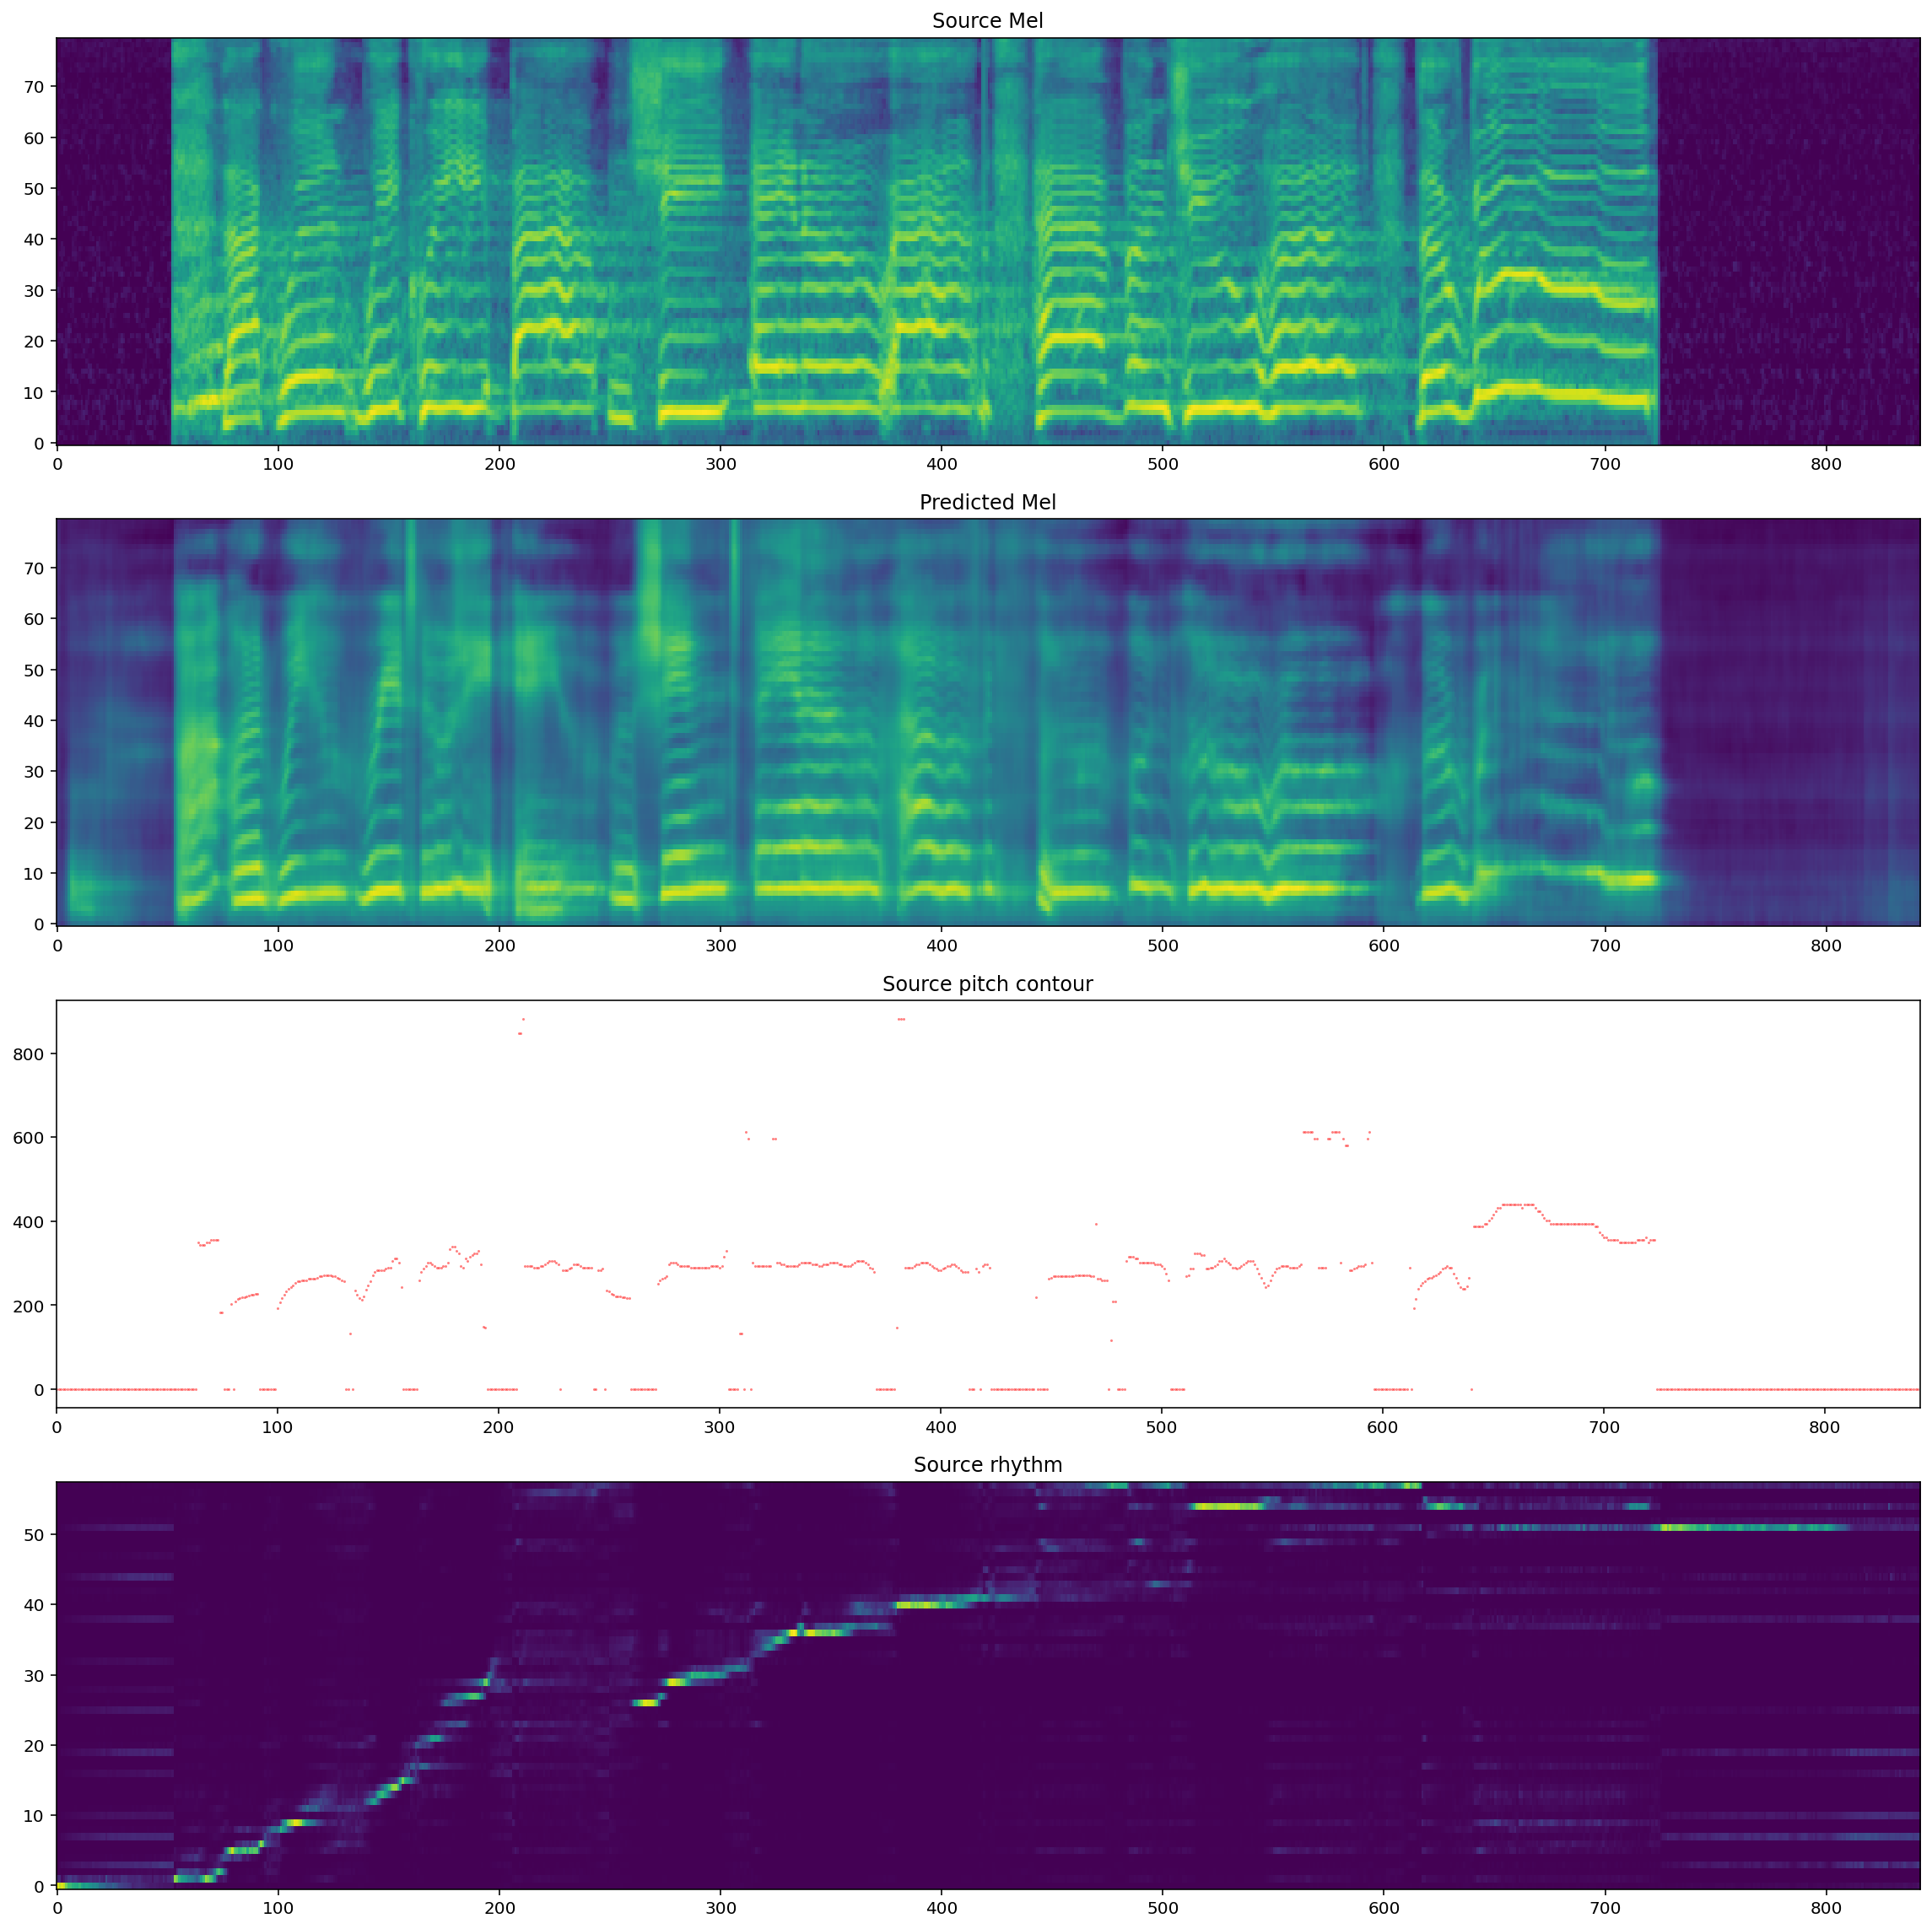

In [34]:
# choose random speaker ID and SEX for synthesis
speaker_id = next(female_speakers) if np.random.randint(2) else next(male_speakers)
speaker_id = torch.LongTensor([speaker_id]).cuda()

# Generate spectrogram
with torch.no_grad():
    mel_outputs, mel_outputs_postnet, gate_outputs, _ = mellotron.inference_noattention(
        (text_encoded, mel, speaker_id, pitch_contour, rhythm))

#Plot spectrogram and addditional info
plot_mel_f0_alignment(x[2].data.cpu().numpy()[0],
                      mel_outputs_postnet.data.cpu().numpy()[0],
                      pitch_contour.data.cpu().numpy()[0, 0],
                      rhythm.data.cpu().numpy()[:, 0].T)

Here we can see the original spectrogram with the predicted spectrogram that will be synthesized into audio. 
The third graph displays predicted pitch contour for the clip.
The last graph shows the alignment of spectrograms.

## Waveform generation with WaveGlow

In [35]:
with torch.no_grad():
    audioWaveglow = denoiser(waveglow.infer(mel_outputs_postnet, sigma=0.8), 0.01)[:, 0]
ipd.Audio(audioWaveglow[0].data.cpu().numpy(), rate=hparams.sampling_rate)

## Replacing WaveGlow with Multi-Singer
This is an attempt to replace waveglof for audiowave generation with a better-suited vocoder - Multisinger.

In [36]:
# return to the absolute path root
%cd /content/
! git clone https://github.com/Rongjiehuang/Multi-Singer.git
%cd Multi-Singer

/content
fatal: destination path 'Multi-Singer' already exists and is not an empty directory.
/content/Multi-Singer


## Infernece for Multi-Singer
The inference for multi-singer is different as it is done from command line via a comand with parameters.


`python inference.py -i data/feature -o outputs/  -c checkpoints/*.pkl -g config/config.yaml`

-i acoustic feature folder

-o directory to save generated speech

-c checkpoints file

-g config file

In [37]:
# make directory for output
! mkdir outputs

mkdir: cannot create directory ‘outputs’: File exists


In [38]:
#create and save mel spectrogram representation from Mellotron
file = open("mel_output.pt", "w")

# it is difficult to determine, in what format is the spectrogram and how to properly save it for import into Multi-singer
torch.save(mel_outputs_postnet.data, 'mel_output.pt')

## Generating audio waveform with Multi-singer
So far this always fails for not accepting the input spectrogram format.

In [39]:
! python inference.py -i mel_output.pt -o outputs/  -c ../models/Basic.pkl -g config/config.yaml

Traceback (most recent call last):
  File "inference.py", line 125, in <module>
    main()
  File "inference.py", line 86, in main
    return_utt_id=True,
  File "/content/Multi-Singer/datasets/audio_mel_dataset.py", line 277, in __init__
    assert len(mel_files) != 0, f"Not found any mel files in ${root_dir}."
AssertionError: Not found any mel files in $mel_output.pt.


## Generating audio waveform with HiFiGAN via NeMo
The following approach demonstrates the possibility of swapping a vocoder module for Mellotron and attaching a different module provided by the NeMo framework.

In [40]:
# import pretrained TTS models
import nemo.collections.tts as nemo_tts

# import pretrained HiFiGAN
from nemo.collections.tts.models import HifiGanModel
hifigan = HifiGanModel.from_pretrained("tts_hifigan").eval().cuda()

[NeMo W 2022-02-27 16:10:02 __init__:23] `pynini` is not installed ! 
    Please run the `nemo_text_processing/setup.sh` script prior to usage of this toolkit.


[NeMo I 2022-02-27 16:10:03 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.7.0/tts_hifigan/e6da322f0f7e7dcf3f1900a9229a7e69/tts_hifigan.nemo.
[NeMo I 2022-02-27 16:10:03 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.7.0/tts_hifigan/e6da322f0f7e7dcf3f1900a9229a7e69/tts_hifigan.nemo
[NeMo I 2022-02-27 16:10:03 common:704] Instantiating model from pre-trained checkpoint


[NeMo W 2022-02-27 16:10:06 modelPT:149] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.MelAudioDataset
      manifest_filepath: /home/fkreuk/data/train_finetune.txt
      min_duration: 0.75
      n_segments: 8192
    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 64
      num_workers: 4
    
[NeMo W 2022-02-27 16:10:06 modelPT:156] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.MelAudioDataset
      manifest_filepath: /home/fkreuk/data/val_finetune.txt
      min_duration: 3
      n_segments: 66150


[NeMo I 2022-02-27 16:10:06 features:255] PADDING: 0
[NeMo I 2022-02-27 16:10:06 features:272] STFT using torch


[NeMo W 2022-02-27 16:10:06 features:233] Using torch_stft is deprecated and will be removed in 1.1.0. Please set stft_conv and stft_exact_pad to False for FilterbankFeatures and AudioToMelSpectrogramPreprocessor. Please set exact_pad to True as needed.


[NeMo I 2022-02-27 16:10:06 features:255] PADDING: 0
[NeMo I 2022-02-27 16:10:06 features:272] STFT using torch
[NeMo I 2022-02-27 16:10:08 save_restore_connector:157] Model HifiGanModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.7.0/tts_hifigan/e6da322f0f7e7dcf3f1900a9229a7e69/tts_hifigan.nemo.


### Audio synthesis from original mel-Spectrogram
The following audio was synthesized via HiFiGAN.

In [41]:
audio = hifigan.convert_spectrogram_to_audio(spec=mel_outputs_postnet).to('cpu').detach().numpy()
ipd.display(ipd.Audio(audio, rate=hparams.sampling_rate))

For comparison, the previous WaveGlow synthesized clip...

In [42]:
ipd.Audio(audioWaveglow[0].data.cpu().numpy(), rate=hparams.sampling_rate)